<a href="https://colab.research.google.com/github/antonshalin76/DataScientist/blob/main/Generation/%D0%93%D0%B5%D0%BD%D0%B5%D1%80%D0%B0%D1%86%D0%B8%D1%8F_%D0%BA%D0%B0%D1%80%D1%82%D0%B8%D0%BD%D0%BE%D0%BA_GAN_%D0%BD%D0%B0_%D0%B4%D0%B0%D1%82%D0%B0%D1%81%D0%B5%D1%82%D0%B5_CIFAR10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Используя датасет CIFAR10 создать и обучить модель генеративно-состязательной сети (GAN). Используем инструменты фреймворка **Chainer**

[Ссылка на документацию](https://docs.chainer.org/en/stable/index.html)

In [ ]:
!pip install chainer

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 6.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for chainer: filename=chainer-7.8.1-py3-none-any.whl size=967716 sha256=b61235f81a3c53aa1ebd6e506d2458096eb9a56f618421d66054ed961414b368
  Stored in directory: /root/.cache/pip/wheels/c4/95/6a/16014db6f761c4e742755b64aac60dbe142da1df6c5919f790
Successfully built chainer


In [ ]:
# загрузим библиотеки
import chainer, os
from chainer import cuda
import chainer.datasets as datasets
import chainer.iterators as iterators
import chainer.functions as F
import chainer.links as L
import chainer.optimizers as optimizers
from chainer import Variable
from chainer.training import extensions
from chainer.training import make_extension
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import chainer.backends.cuda
import glob

In [ ]:
# установим параметры
n_epoch = 50  # число эпох
n_hidden = 100  # размер скрытого пространства векторов
batchsize = 50  # размер minibatch
snapshot_interval = 10000  # число итераций на одно формирование картинок
display_interval = 2000  # число итераций на вывод статуса и параметров обучения
gpu_id = 0
out_dir = 'result'
seed = 0  # random seed

# загрузка датасета и подготовка данных к обучению
train, _ = chainer.datasets.get_cifar10(withlabel=False, scale=255.)
train_iter = chainer.iterators.SerialIterator(train, batchsize)

In [ ]:
# определим класс генератора
class Generator(chainer.Chain):
    def __init__(self, n_hidden, bottom_width=4, ch=512, wscale=0.02):
        super(Generator, self).__init__()
        self.n_hidden = n_hidden
        self.ch = ch
        self.bottom_width = bottom_width

        with self.init_scope():
            w = chainer.initializers.Normal(wscale)
            self.l0 = L.Linear(self.n_hidden, bottom_width * bottom_width * ch,
                               initialW=w)
            self.dc1 = L.Deconvolution2D(ch, ch // 2, 4, 2, 1, initialW=w)
            self.dc2 = L.Deconvolution2D(ch // 2, ch // 4, 4, 2, 1, initialW=w)
            self.dc3 = L.Deconvolution2D(ch // 4, ch // 8, 4, 2, 1, initialW=w)
            self.dc4 = L.Deconvolution2D(ch // 8, 3, 3, 1, 1, initialW=w)
            self.bn0 = L.BatchNormalization(bottom_width * bottom_width * ch)
            self.bn1 = L.BatchNormalization(ch // 2)
            self.bn2 = L.BatchNormalization(ch // 4)
            self.bn3 = L.BatchNormalization(ch // 8)
    def make_hidden(self, batchsize):
        return np.random.uniform(-1, 1, (batchsize, self.n_hidden, 1, 1)).astype(np.float32)
    def __call__(self, z):
        h = F.reshape(F.relu(self.bn0(self.l0(z))),
                                (len(z), self.ch, self.bottom_width, self.bottom_width))
        h = F.relu(self.bn1(self.dc1(h)))
        h = F.relu(self.bn2(self.dc2(h)))
        h = F.relu(self.bn3(self.dc3(h)))
        x = F.sigmoid(self.dc4(h))
        return x

# определим класс дискриминатора (глубже, чем генератор и с другой фукцией активации leacky_relu)
class Discriminator(chainer.Chain):
    def __init__(self, bottom_width=4, ch=512, wscale=0.02):
        w = chainer.initializers.Normal(wscale)
        super(Discriminator, self).__init__()
        with self.init_scope():
            self.c0_0 = L.Convolution2D(3, ch // 8, 3, 1, 1, initialW=w)
            self.c0_1 = L.Convolution2D(ch // 8, ch // 4, 4, 2, 1, initialW=w)
            self.c1_0 = L.Convolution2D(ch // 4, ch // 4, 3, 1, 1, initialW=w)
            self.c1_1 = L.Convolution2D(ch // 4, ch // 2, 4, 2, 1, initialW=w)
            self.c2_0 = L.Convolution2D(ch // 2, ch // 2, 3, 1, 1, initialW=w)
            self.c2_1 = L.Convolution2D(ch // 2, ch // 1, 4, 2, 1, initialW=w)
            self.c3_0 = L.Convolution2D(ch // 1, ch // 1, 3, 1, 1, initialW=w)
            self.l4 = L.Linear(bottom_width * bottom_width * ch, 1, initialW=w)
            self.bn0_1 = L.BatchNormalization(ch // 4, use_gamma=False)
            self.bn1_0 = L.BatchNormalization(ch // 4, use_gamma=False)
            self.bn1_1 = L.BatchNormalization(ch // 2, use_gamma=False)
            self.bn2_0 = L.BatchNormalization(ch // 2, use_gamma=False)
            self.bn2_1 = L.BatchNormalization(ch // 1, use_gamma=False)
            self.bn3_0 = L.BatchNormalization(ch // 1, use_gamma=False)
    def __call__(self, x):
        h = add_noise(x)
        h = F.leaky_relu(add_noise(self.c0_0(h)))
        h = F.leaky_relu(add_noise(self.bn0_1(self.c0_1(h))))
        h = F.leaky_relu(add_noise(self.bn1_0(self.c1_0(h))))
        h = F.leaky_relu(add_noise(self.bn1_1(self.c1_1(h))))
        h = F.leaky_relu(add_noise(self.bn2_0(self.c2_0(h))))
        h = F.leaky_relu(add_noise(self.bn2_1(self.c2_1(h))))
        h = F.leaky_relu(add_noise(self.bn3_0(self.c3_0(h))))
        return self.l4(h)

# добавим шума для дискриминатора
def add_noise(h, sigma=0.2):
    xp = cuda.get_array_module(h.data)
    if chainer.config.train:
        return h + sigma * xp.random.randn(*h.shape)
    else:
        return h

# создадим экземпляры генератора и дискриминатора
gen = Generator(n_hidden=n_hidden)
dis = Discriminator()

# сделаем оптимизаторы для моделей, созданных выше
def make_optimizer(model, alpha=0.0002, beta1=0.5):
    optimizer = chainer.optimizers.Adam(alpha=alpha, beta1=beta1)
    optimizer.setup(model)
    optimizer.add_hook(
        chainer.optimizer_hooks.WeightDecay(0.0001), 'hook_dec')
    return optimizer

opt_gen = make_optimizer(gen)
opt_dis = make_optimizer(dis)

# подготовка и обучение updater · тренера
class DCGANUpdater(chainer.training.updaters.StandardUpdater):
    def __init__(self, *args, **kwargs):
        self.gen, self.dis = kwargs.pop('models')
        super(DCGANUpdater, self).__init__(*args, **kwargs)
    def loss_dis(self, dis, y_fake, y_real):
        batchsize = len(y_fake)
        L1 = F.sum(F.softplus(-y_real)) / batchsize
        L2 = F.sum(F.softplus(y_fake)) / batchsize
        loss = L1 + L2
        chainer.report({'loss': loss}, dis)
        return loss
    def loss_gen(self, gen, y_fake):
        batchsize = len(y_fake)
        loss = F.sum(F.softplus(-y_fake)) / batchsize
        chainer.report({'loss': loss}, gen)
        return loss
    def update_core(self):
        gen_optimizer = self.get_optimizer('gen')
        dis_optimizer = self.get_optimizer('dis')

        batch = self.get_iterator('main').next()
        x_real = Variable(self.converter(batch, self.device)) / 255.
        xp = chainer.backends.cuda.get_array_module(x_real.data)

        gen, dis = self.gen, self.dis
        batchsize = len(batch)

        y_real = dis(x_real)

        z = Variable(xp.asarray(gen.make_hidden(batchsize)))
        x_fake = gen(z)
        y_fake = dis(x_fake)

        dis_optimizer.update(self.loss_dis, dis, y_fake, y_real)
        gen_optimizer.update(self.loss_gen, gen, y_fake)

# создадим экземпляры апдейтера и тренера для генератора и дискриминатора
updater = DCGANUpdater(models=(gen, dis), iterator=train_iter, optimizer={'gen': opt_gen, 'dis': opt_dis},device=gpu_id)
trainer = chainer.training.Trainer(updater, (n_epoch, 'epoch'), out=out_dir)

# нагенерим через модель картинки, используя extention chainer
def out_generated_image(gen, dis, rows, cols, seed, dst):
    @chainer.training.make_extension()
    def make_image(trainer):
        np.random.seed(seed)
        n_images = rows * cols
        xp = gen.xp
        z = Variable(xp.asarray(gen.make_hidden(n_images)))
        with chainer.using_config('train', False):
            x = gen(z)
        x = chainer.backends.cuda.to_cpu(x.data)
        np.random.seed()

        x = np.asarray(np.clip(x * 255, 0.0, 255.0), dtype=np.uint8)
        _, _, H, W = x.shape
        x = x.reshape((rows, cols, 3, H, W))
        x = x.transpose(0, 3, 1, 4, 2)
        x = x.reshape((rows * H, cols * W, 3))

        preview_dir = '{}/preview'.format(dst)
        preview_path = preview_dir +\
            '/image{:0>8}.png'.format(trainer.updater.iteration)
        if not os.path.exists(preview_dir):
            os.makedirs(preview_dir)
        Image.fromarray(x).save(preview_path)
    return make_image

# зададим интервалы вывода в консоль и в файлы
snapshot_interval = (snapshot_interval, 'iteration')
display_interval = (display_interval, 'iteration')

# выведем параметры процесса обучения
trainer.extend(extensions.LogReport(trigger=display_interval))
trainer.extend(extensions.PrintReport(['epoch', 'iteration', 'gen/loss', 'dis/loss',]), trigger=display_interval)

# создадим картинки с заданным интервалом генерации
trainer.extend(out_generated_image(gen, dis, 10, 10, seed, out_dir), trigger=snapshot_interval)

# запустим процесс
trainer.run()

/usr/local/lib/python3.10/dist-packages/chainer/functions/connection/convolution_2d.py:295: PerformanceWarning: The best algo of conv fwd might not be selected due to lack of workspace size (8388608)
  cuda.cudnn.convolution_forward(


epoch       iteration   gen/loss    dis/loss  
2           2000        1.16309     1.2464      
4           4000        1.26867     1.12865     
6           6000        1.23407     1.12746     
8           8000        1.3239      1.05743     
10          10000       1.53418     0.942808    
12          12000       1.73074     0.869179    
14          14000       1.80145     0.837924    
16          16000       1.91547     0.801525    
18          18000       1.97466     0.782051    
20          20000       2.08728     0.745834    
22          22000       2.15257     0.729615    
24          24000       2.23858     0.700547    
26          26000       2.33904     0.679113    
28          28000       2.37093     0.673127    
30          30000       2.45848     0.635788    
32          32000       2.48344     0.630158    
34          34000       2.56099     0.629244    
36          36000       2.62864     0.581779    
38          38000       2.68246     0.599562    
40          40000     

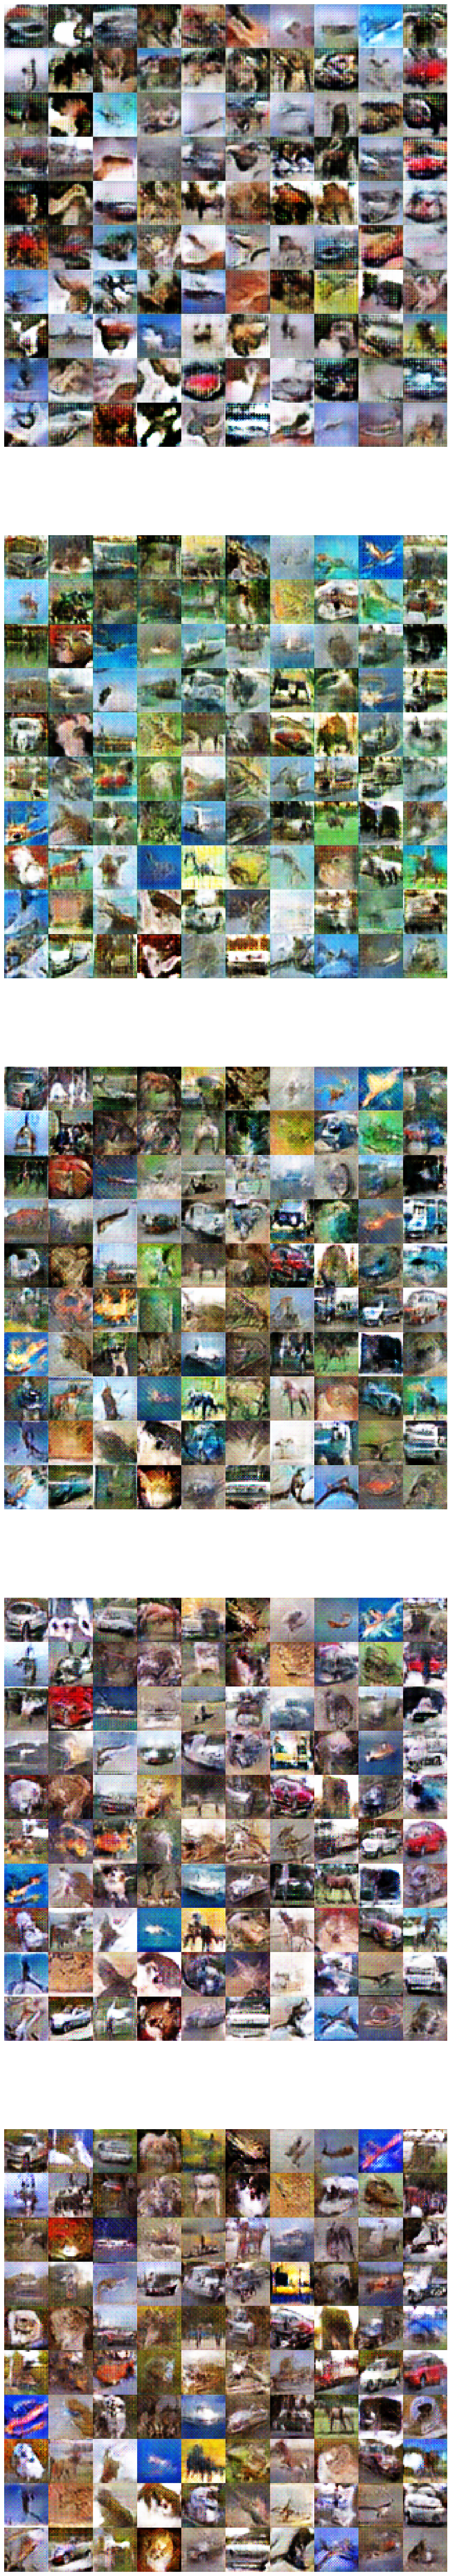

In [ ]:
# прочитаем созданные картинки
image_files = sorted(glob.glob(out_dir + '/preview/*.png'))

# определим кол-во файлов
file_count = len(os.listdir(out_dir + '/preview/'))

# выведем получившиеся изображения на разных этапах формирования модели
plt.figure(figsize=(80, 80))
for i in range(file_count):
    plt.subplot(file_count, 1, i + 1)
    plt.imshow(np.asarray(Image.open(image_files[i])))
    plt.axis('off')
plt.show()
plt.close() # Завершаем работу с plt